# Import Packages

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Capstone/Dataset'
os.listdir(path)

['train', 'val']

In [ ]:
train_dir = os.path.join(path, 'train')
val_dir = os.path.join(path, 'val')

In [ ]:
soil_types = os.listdir(train_dir)
soil_types.sort()
soil_types

['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']

In [ ]:
for i in os.listdir(train_dir):
  print(f"There are {len(os.listdir(os.path.join(train_dir, i)))} in {i}")

There are 228 in Black Soil
There are 523 in Alluvial soil
There are 197 in Clay soil
There are 267 in Red soil


In [ ]:
for i in os.listdir(val_dir):
  print(f"There are {len(os.listdir(os.path.join(val_dir, i)))} in {i}")

There are 65 in Clay soil
There are 53 in Alluvial soil
There are 116 in Black Soil
There are 106 in Red soil


# Image Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
  )

Found 1215 images belonging to 4 classes.
Found 340 images belonging to 4 classes.


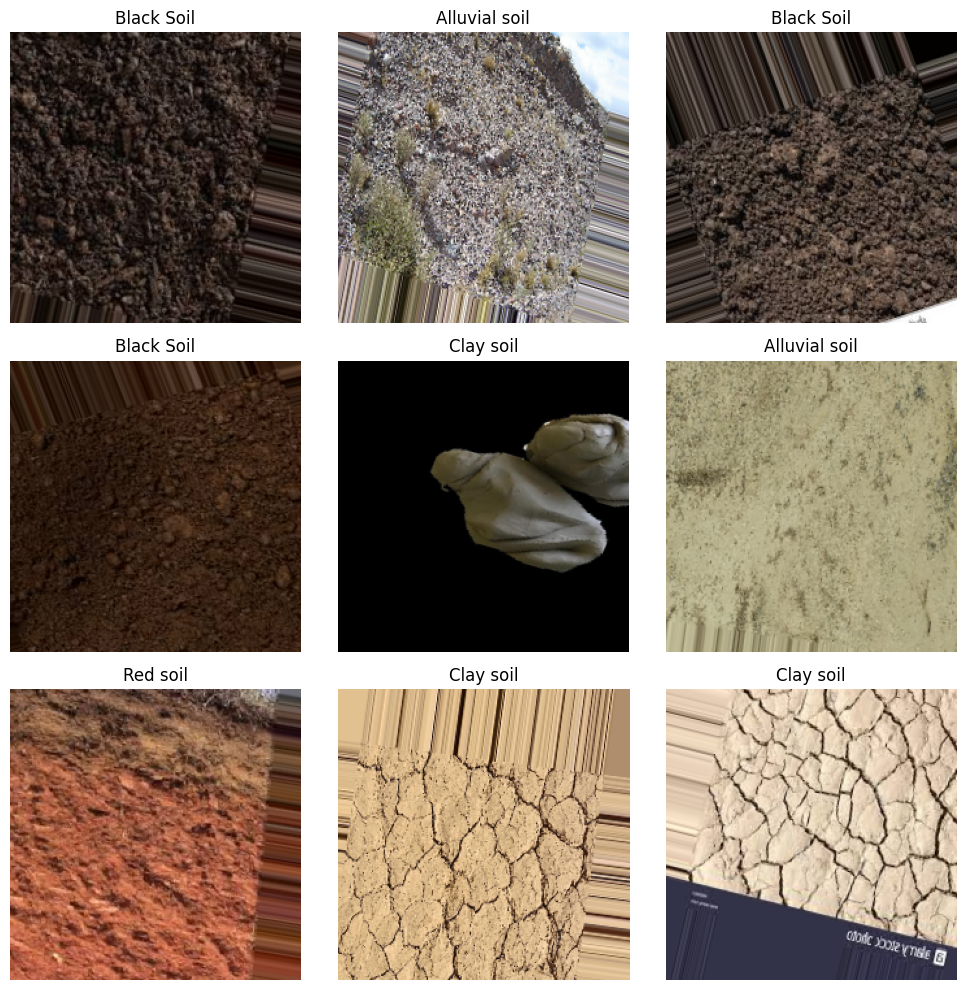

In [ ]:
images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(min(len(images), 9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"{soil_types[tf.argmax(labels[i])]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Training Model

In [ ]:
MobileNetV2_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')

In [ ]:
MobileNetV2_model.trainable = False

In [ ]:
model = tf.keras.Sequential([
    MobileNetV2_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer='l2')
])

model.build((None,)+(224, 224)+(3,))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_3 (Flatten)         (None, 62720)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               8028288   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 10286788 (39.24 MB)
Trainable params: 8028804 (30.63 MB)
Non-trainable params: 2257984 (8.61 MB)
_________

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
Callback = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Capstone/Model/Checkpoint/TanamPintar_Model.h5",
                                             monitor='accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max'
                                             )

Early_Stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [ ]:
history = model.fit(train_generator,
          epochs = 30,
          validation_data = validation_generator,
          callbacks=[Callback, Early_Stopping],
          verbose=1)

Epoch 1/30
76/76 [==============================] - ETA: 0s - loss: 4.1298 - accuracy: 0.6132
Epoch 1: accuracy improved from -inf to 0.61317, saving model to /content/drive/MyDrive/Capstone/Model/Checkpoint/TanamPintar_Model.h5
76/76 [==============================] - 120s 1s/step - loss: 4.1298 - accuracy: 0.6132 - val_loss: 0.9383 - val_accuracy: 0.6588
Epoch 2/30
76/76 [==============================] - ETA: 0s - loss: 0.7986 - accuracy: 0.7309
Epoch 2: accuracy improved from 0.61317 to 0.73086, saving model to /content/drive/MyDrive/Capstone/Model/Checkpoint/TanamPintar_Model.h5
76/76 [==============================] - 107s 1s/step - loss: 0.7986 - accuracy: 0.7309 - val_loss: 0.8612 - val_accuracy: 0.6941
Epoch 3/30
76/76 [==============================] - ETA: 0s - loss: 0.7065 - accuracy: 0.7794
Epoch 3: accuracy improved from 0.73086 to 0.77942, saving model to /content/drive/MyDrive/Capstone/Model/Checkpoint/TanamPintar_Model.h5
76/76 [==============================] - 111s 1

#Plot Model Performance During Training

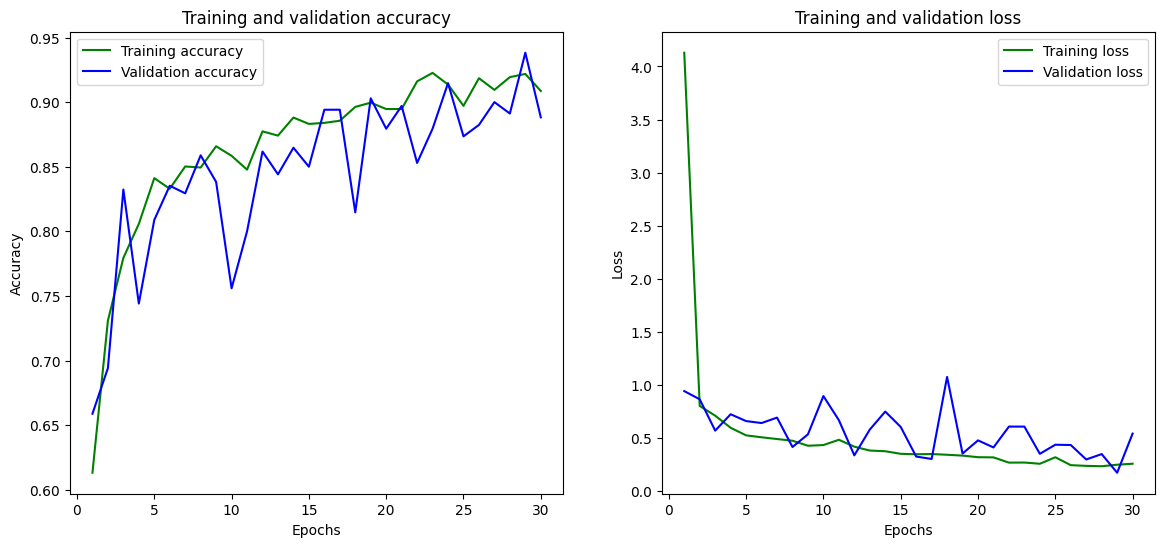

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'g-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'g-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Try Model on Image from Validation Data

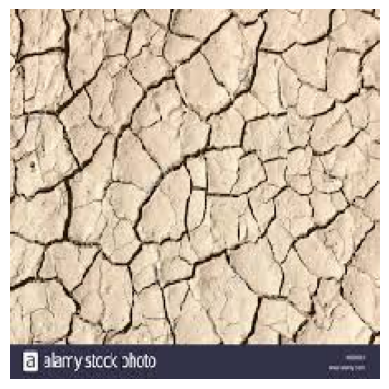

1/1 [==============================] - 0s 71ms/step
True label: Clay soil
Predicted label: Clay soil


In [ ]:
def get_class_string_from_index(index, class_indices):
    for class_string, class_index in class_indices.items():
        if class_index == index:
            return class_string
    return None

x_batch, y_batch = next(validation_generator)

image = x_batch[0]
true_index = np.argmax(y_batch[0])

plt.imshow(image)
plt.axis('off')
plt.show()

expanded_image = np.expand_dims(image, axis=0)

prediction_scores = model.predict(expanded_image)
predicted_index = np.argmax(prediction_scores)

true_label = get_class_string_from_index(true_index, validation_generator.class_indices)
predicted_label = get_class_string_from_index(predicted_index, validation_generator.class_indices)

print(f'True label: {true_label}')
print(f'Predicted label: {predicted_label}')

# Plot Confusion Matrix

22/22 [==============================] - 21s 897ms/step


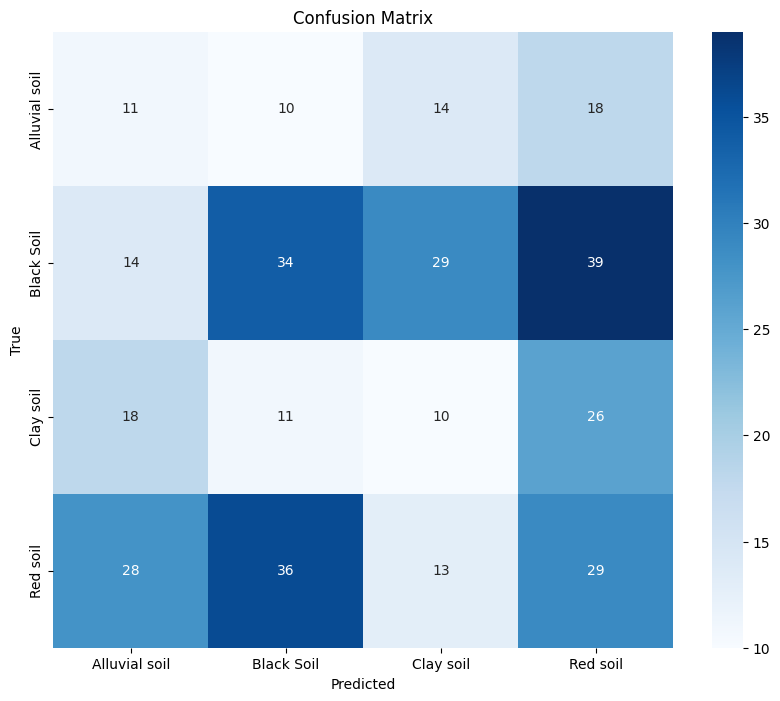

In [ ]:
batch_size = 32

# Reset the validation generator
validation_generator.reset()

# Predict on the ENTIRE validation set, not just a subset
predictions = model.predict(validation_generator, steps=None)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Load Model

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Capstone/Model/Checkpoint/TanamPintar_Model.h5")

In [ ]:
tf.saved_model.save(model, "/content/drive/MyDrive/Capstone/Model/Checkpoint/TanamPintar_Model_new.h5")

# Import Model to JSON

In [ ]:
# pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format=keras --output_format=tfjs_layers_model "/content/drive/MyDrive/Capstone/Model/Checkpoint/TanamPintar_Model.h5" "/content/drive/MyDrive/Capstone/Model/Checkpoint/TanamPintar_Model_JSON"

2024-06-15 11:19:10.087990: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 11:19:15.593210: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
